In [1]:
import pandas as pd
import numpy as np
import sys
import os
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.family'] = 'sans-serif'


In [2]:
df = pd.read_csv("./dataset/new_bgg_data_after_eda2_new.csv", encoding="utf-8")
df.drop(columns=["Rank", "Id", "Name", "Users_rated"], inplace=True)
# df.drop(columns=["Time", "Mintime", "Maxtime", "Age", "Minplayers", "Maxplayers",
        # "Nmechanics", "Ndomains", "Ncategory", "Nartist", "Ndesign"], inplace=True)


In [3]:
test_size = 0.2
random_state = 42


In [4]:
from sklearn.model_selection import train_test_split


def get_Xs_Ys(df, target, exclude, use_val=True):

    assert type(target) == list, "target must be list"
    assert type(exclude) == list, "exclude must be list"

    train, test = train_test_split(
         df,
         test_size=test_size,
         random_state=random_state)
    if use_val:
        train, val = train_test_split(
            train,
            test_size=test_size,
            random_state=random_state)

    def get_y(data): return data[target]
    def get_x(data): return data.drop(columns=target + exclude)

    Ys = {"train": get_y(train),
        "test": get_y(test)}
    Xs = {"train": get_x(train),
        "test": get_x(test)}

    if use_val:
        Ys['val'] = get_y(val)
        Xs['val'] = get_x(val)

    return Xs, Ys, target


Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], [
                                "Sug_players", "Sug_age", "Language_dependence", "Own"])


In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def eval_models(y_pred, y_true, verbose=False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if verbose:

        return {"MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2}
    else:
        return mse, rmse, mae, r2


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline


In [7]:
def make_simple_linear(sk_args={}, lrg_arg={}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        LinearRegression(**lrg_arg),
    )


In [8]:


def result_regress(model, Xs, Ys, y_order):

    scaler = StandardScaler()

    x_train = pd.DataFrame(scaler.fit_transform(
        Xs['train']), columns=Xs['train'].columns)
    x_val = pd.DataFrame(scaler.transform(
        Xs['val']), columns=Xs['val'].columns)
    x_test = pd.DataFrame(scaler.transform(
        Xs['test']), columns=Xs['test'].columns)

    model.fit(x_train, Ys['train'].iloc[:, y_order])

    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    y_pred_test = model.predict(x_test)

    eval_train = eval_models(y_pred_train, Ys['train'].iloc[:, y_order])
    eval_val = eval_models(y_pred_val, Ys['val'].iloc[:, y_order])
    eval_test = eval_models(y_pred_test, Ys['test'].iloc[:, y_order])

    return pd.DataFrame([eval_train, eval_val, eval_test], columns=["MSE", "RMSE", "MAE", "R2"], index=["train", "validation", "test"])


In [9]:
result_regress(make_simple_linear(), Xs, Ys, 0)   # Rating


,MSE,RMSE,MAE,R2
train,0.606281,0.778640,0.597537,0.293833
validation,0.591438,0.769050,0.589534,0.313375
test,0.618930,0.786721,0.605074,0.276769


In [10]:
result_regress(make_simple_linear(), Xs, Ys, 1)   # Complexity


,MSE,RMSE,MAE,R2
train,0.354064,0.595032,0.454576,0.484550
validation,0.332355,0.576502,0.438211,0.494751
test,0.347504,0.589494,0.453749,0.504061


In [11]:

from sklearn.model_selection import GridSearchCV


def find_best_k(df, results=False):
    params = {

        # 'selectkbest__k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        'selectkbest__k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], [
                                    "Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()

    x_train = pd.DataFrame(scaler.fit_transform(
        Xs['train']), columns=Xs['train'].columns)

    grid_searchs = []

    for i in tqdm(range(len(target_list))):
        grid_search = GridSearchCV(make_simple_linear(
        ), param_grid=params, scoring="r2", cv=5, verbose=1)
        grid_search.fit(x_train, Ys['train'].iloc[:, i])

        grid_searchs.append(grid_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", grid_search.best_params_)
        print("Best R2 Score: ", grid_search.best_score_)

    if results:
        return grid_searchs, scaler


In [12]:
linear_model, scaler = find_best_k(df, results=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Target : Rating
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.3673625920820901
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Target : Complexity
Best parameter:  {'selectkbest__k': 140}
Best R2 Score:  0.6013729930439119


In [13]:
def test_eval(x_test, y_test, model, target_list, scaler=None):

    if scaler is not None:
        x_test = x_test.copy()
        x_test = scaler.transform(x_test)
        x_test = pd.DataFrame(x_test, columns=Xs['test'].columns)

    eval_tests = []
    for i in range(len(target_list)):

        eval_test = eval_models(model[i].predict(
            x_test), Ys['test'][target_list[i]])
        eval_tests.append(eval_test)

    return pd.DataFrame(eval_tests, index=target_list, columns=["MSE", "RMSE", "MAE", "R2"])


In [14]:
simple_linear_test_eval = test_eval(
    Xs['test'], Ys['test'], linear_model, target_list, scaler=scaler)


In [15]:
simple_linear_test_eval


,MSE,RMSE,MAE,R2
Rating,0.546773,0.739441,0.563653,0.361086
Complexity,0.263137,0.512969,0.374856,0.624464


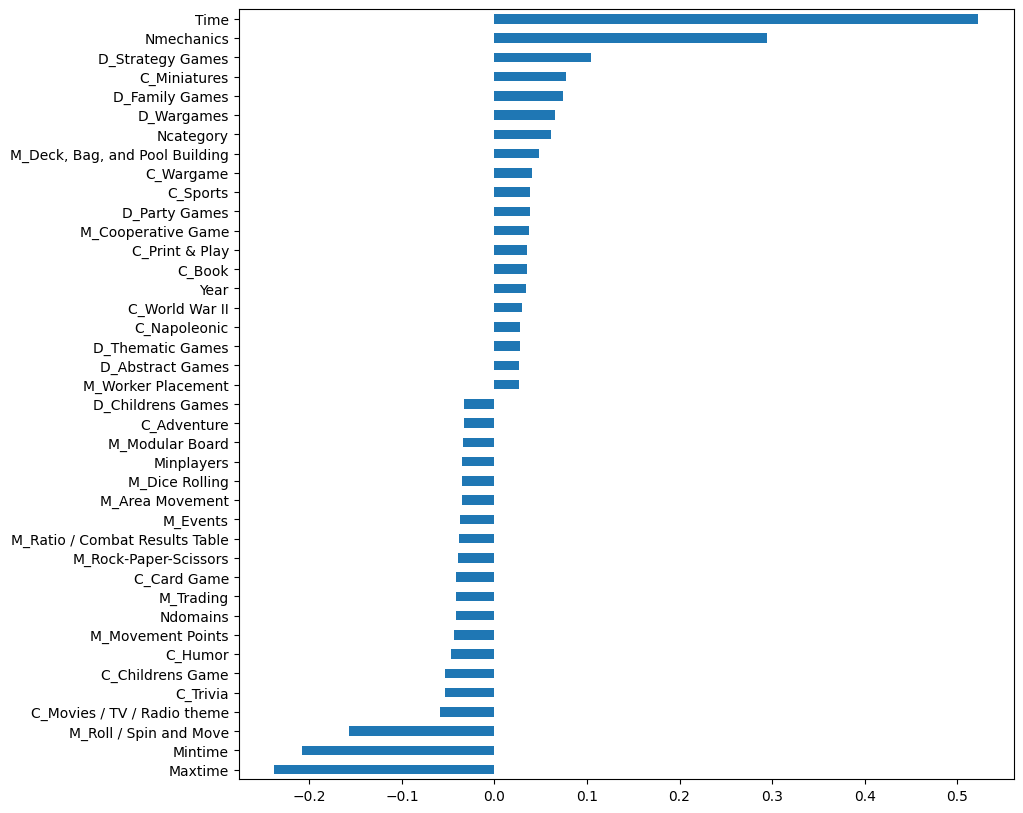

In [16]:
# check last model about Rating
coef_ = pd.Series(linear_model[0].best_estimator_['linearregression'].coef_,
                  index=linear_model[0].best_estimator_['selectkbest'].get_feature_names_out()).sort_values(ascending=False)
# coef_[:8].sort_values().plot.barh(figsize=(6, 15))
pd.concat([coef_.head(20), coef_.tail(20)]
          ).sort_values().plot.barh(figsize=(10, 10))
plt.show()


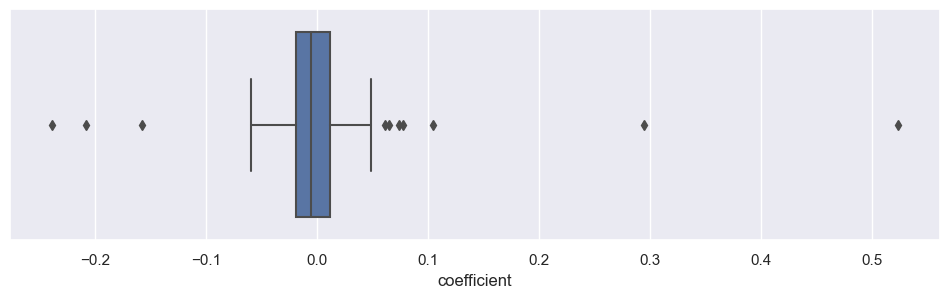

In [17]:
# 엄청나게 비대칭적인 계수 현황
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()


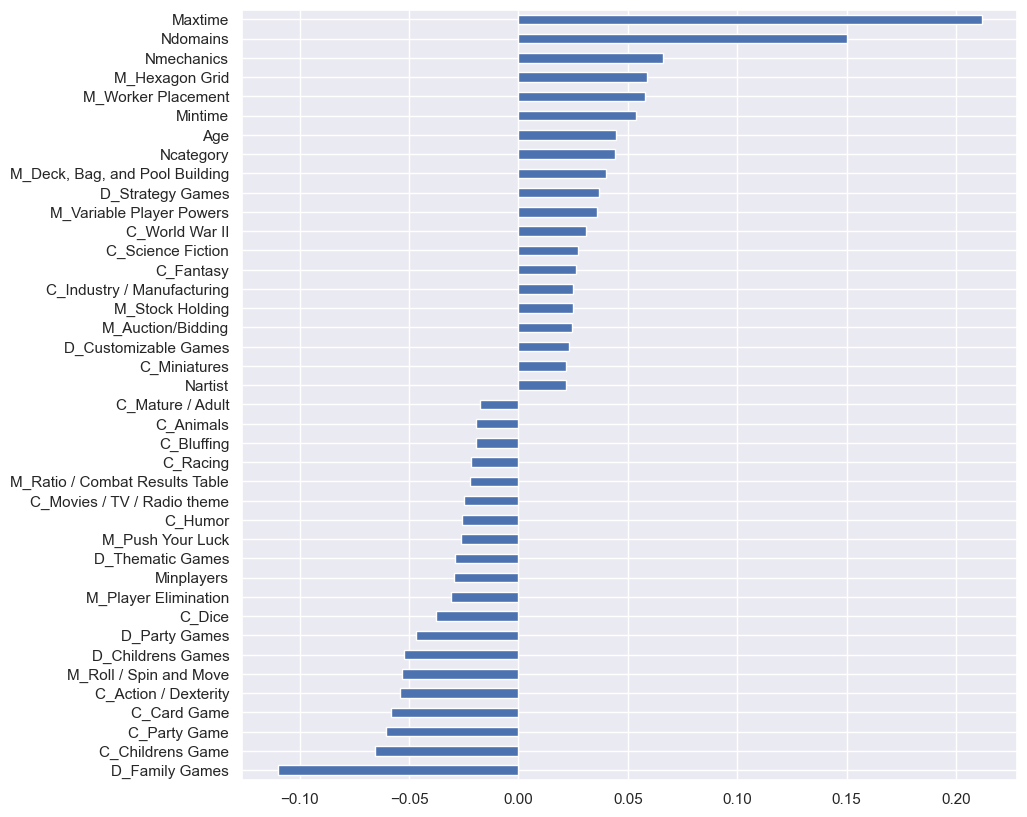

In [18]:
# check last model about Complexity
coef_ = pd.Series(linear_model[1].best_estimator_['linearregression'].coef_,
                  index=linear_model[1].best_estimator_['selectkbest'].get_feature_names_out()).sort_values(ascending=False)
pd.concat([coef_.head(20), coef_.tail(20)]
          ).sort_values().plot.barh(figsize=(10, 10))

plt.show()


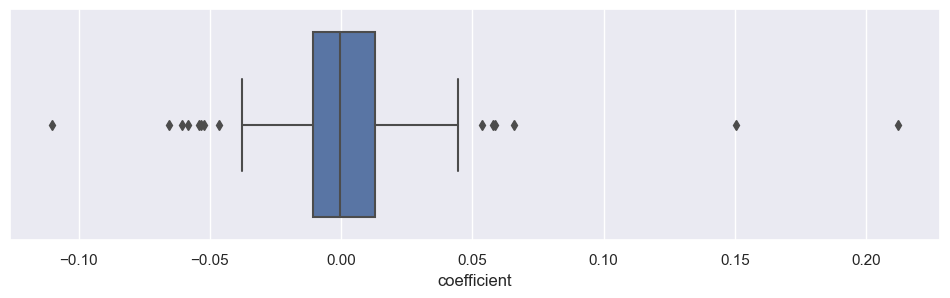

In [19]:
# 엄청나게 비대칭적인 계수 현황
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()


In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV


def make_ridge(sk_args={}, rd_args={}):
    return make_pipeline(
        SelectKBest(score_func=f_regression),
        Ridge(**rd_args, random_state=random_state),
    )


In [21]:
def find_best_param_randomly(df, results=False):
    params = {
        'selectkbest__k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
        # 'selectkbest__k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 140],
        'ridge__alpha': np.random.uniform(1e-4, 1e+5, 100)
    }
    Xs, Ys, target_list = get_Xs_Ys(df, ["Rating", "Complexity"], [
                                    "Sug_players", "Sug_age", "Language_dependence", "Own"], use_val=False)

    scaler = StandardScaler()

    x_train = pd.DataFrame(scaler.fit_transform(
        Xs['train']), columns=Xs['train'].columns)

    random_searchs = []

    for i in tqdm(range(len(target_list))):
        random_search = RandomizedSearchCV(make_ridge(), params, n_iter=100,
                                           n_jobs=-1, random_state=random_state, cv=5)
        random_search.fit(x_train, Ys['train'].iloc[:, i])

        random_searchs.append(random_search)
        print(f"Target : {target_list[i]}")
        print("Best parameter: ", random_search.best_params_)
        print("Best R2 Score: ", random_search.best_score_)

    if results:
        return random_searchs, scaler


In [22]:
ridge_model, scaler= find_best_param_randomly(df, results=True)  # with no engineering


  0%|          | 0/2 [00:00<?, ?it/s]

Target : Rating
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 983.020177813528}
Best R2 Score:  0.36335688522584064
Target : Complexity
Best parameter:  {'selectkbest__k': 130, 'ridge__alpha': 983.020177813528}
Best R2 Score:  0.600687612626073


In [23]:
ridge_test_eval = test_eval(Xs['test'], Ys['test'], ridge_model, target_list, scaler = scaler)

In [24]:
ridge_test_eval


,MSE,RMSE,MAE,R2
Rating,0.550806,0.742163,0.567174,0.356373
Complexity,0.263621,0.513441,0.375200,0.623773


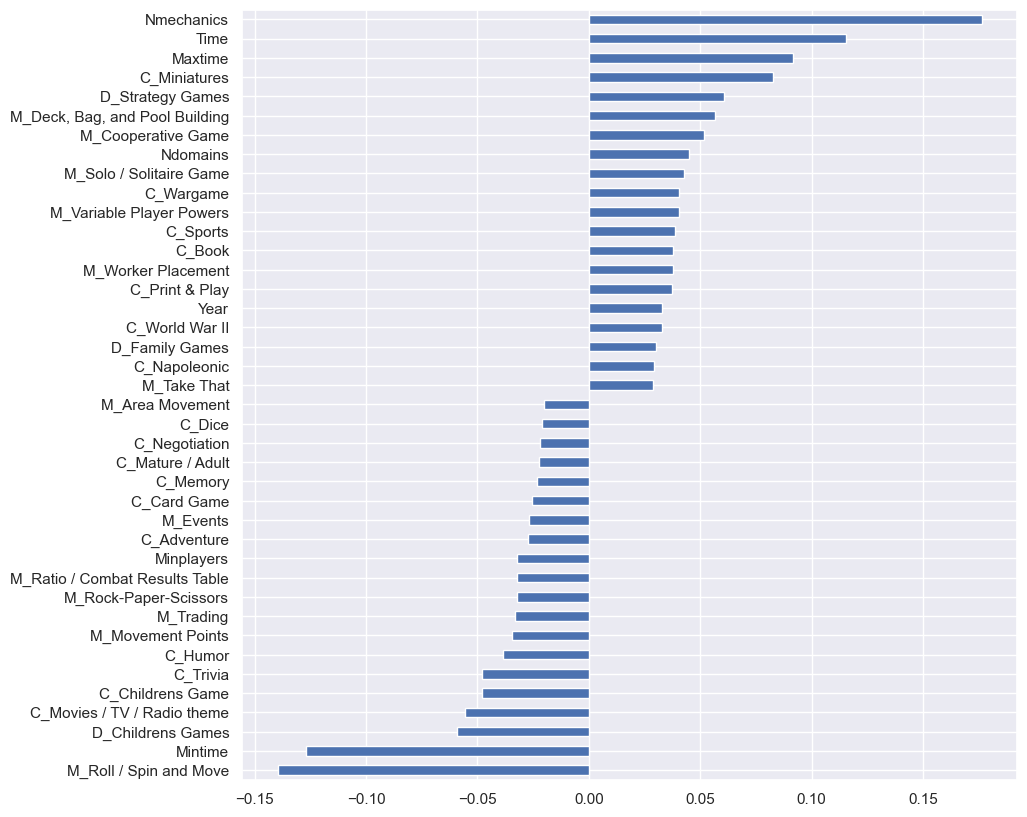

In [25]:
# check last model about Rating
coef_ = pd.Series(ridge_model[0].best_estimator_['ridge'].coef_,
                  index=ridge_model[0].best_estimator_['selectkbest'].get_feature_names_out()).sort_values()

pd.concat([coef_.head(20), coef_.tail(20)]).plot.barh(figsize=(10, 10))
plt.show()


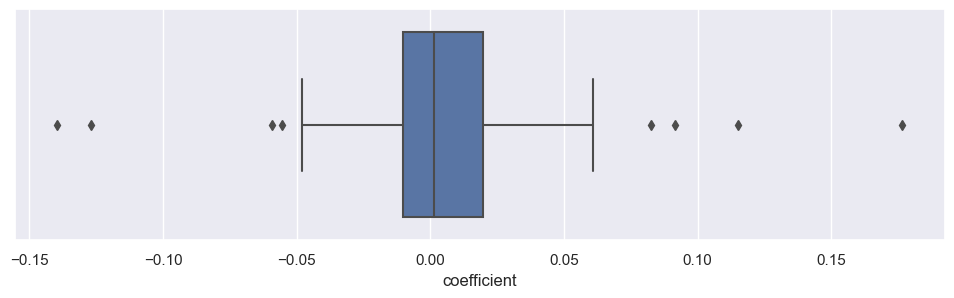

In [26]:
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()


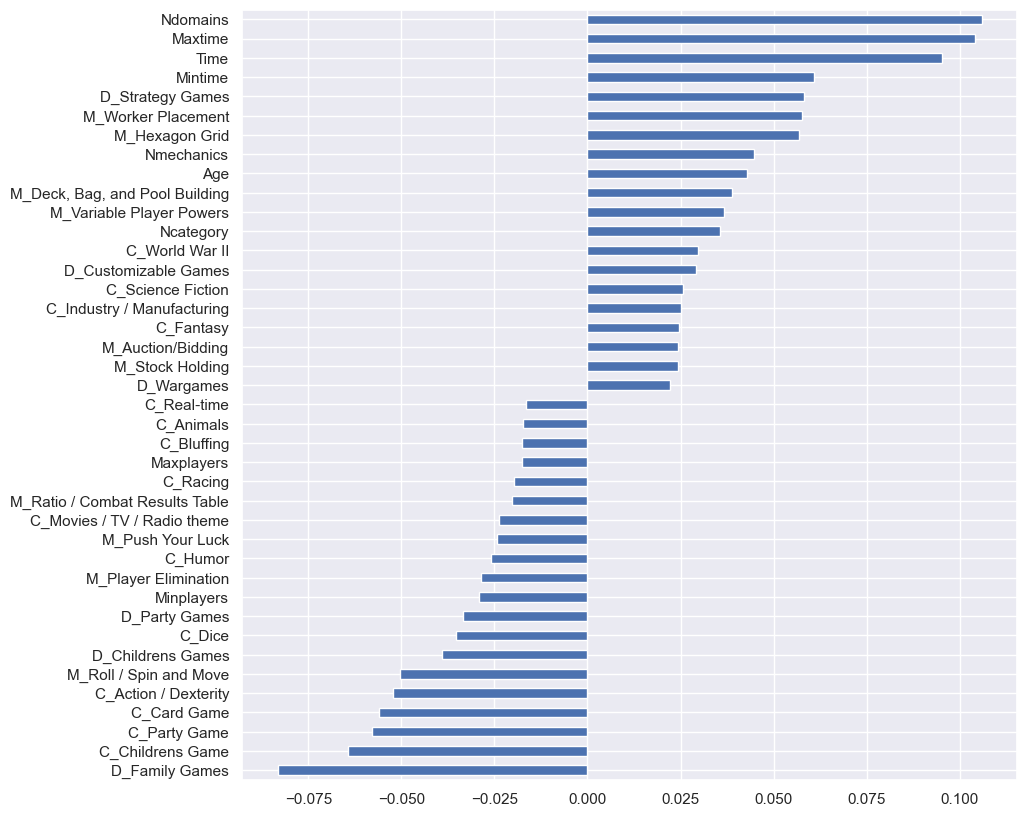

In [27]:
# check last model about Complexity
matplotlib.rcParams['font.family'] = 'sans-serif'
coef_ = pd.Series(ridge_model[1].best_estimator_['ridge'].coef_,
                  index=ridge_model[1].best_estimator_['selectkbest'].get_feature_names_out()).sort_values()

pd.concat([coef_.head(20), coef_.tail(20)]).plot.barh(figsize=(10, 10))
plt.show()


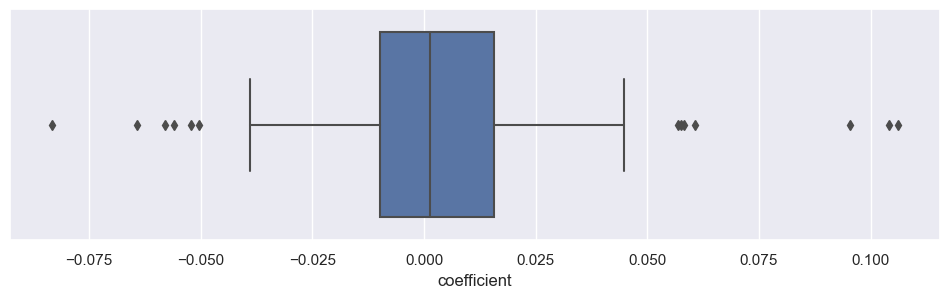

In [28]:
sns.set(rc={'figure.figsize': (12, 3)})
ax = sns.boxplot(x=coef_)
ax.set(xlabel='coefficient')
plt.show()
